# --------------------------------Humpback Whale Identification----------------------------------


In [1]:
################################################### Imports ################################################################

import PIL
import random
import os
import pickle
import shutil
import csv
import cv2
import scipy.misc
import time
import math
import numpy               as np 
import pandas              as pd
import matplotlib.pyplot   as plt
import imgaug              as ia

from PIL                   import Image
from tqdm                  import tqdm
from os.path               import isfile
from imagehash             import phash
from shutil                import copyfile
from imgaug                import augmenters as iaa
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing   import image
from collections           import Counter
from keras.models          import load_model
from keras.metrics         import top_k_categorical_accuracy
from keras.optimizers      import Adam
from keras.models          import Model
from keras.models          import load_model
from keras.callbacks       import ModelCheckpoint
from keras.callbacks       import EarlyStopping
from keras                 import regularizers
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, AveragePooling2D
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.preprocessing.image import ImageDataGenerator



Using TensorFlow backend.


In [5]:
###############################################  Constants ############################################################################

SAMPLE_FILE           = '/home/or/whales/sample_submission.csv' # The sample submission file
TEST_FOLDER           = '/home/or/whales/test'                  # Folder of all the test pic
TRAINING_FILE         = "./train.csv"                           # The test csv file
TRAIN_FOLDER          = '/home/or/whales/train'                 # Folder of all the train pic
H2PS                  = "/home/or/whales/h2ps.pickle"           # All the oic tha has the same hash
P2H                   = "/home/or/whales/p2h.pickle"            # Pic to hash matching
H2P                   = "/home/or/whales/h2p.pickle"            # Hash to pic matching
P2SIZE                = "/home/or/whales/p2size.pickle"         # Size of picures
CONV_TRAIN_FILE       = "/home/or/whales/conv_train.csv"        # Train.csv after update close pictures
CONV_SUB_FILE         = "/home/or/whales/conv_sub.csv"          # Submission.csv after update close pictures
TRAINING_FILE_3_NO_W  = "/home/or/whales/train_3channel.csv"    # Updated train.csv after transform all pic to 3 cahnnels withput 'new_whale'
TRAIN_FOLDER_3CHANNEL = '/home/or/whales/train_3channel'        # Updated train.csv pic directory
TRAINING_FILE_FINAL_A = "/home/or/whales/train_aug_final.csv"   # Updated train.csv after transform with augmentation of pictures
TRAINING_FILE_FINAL   = "/home/or/whales/train_final.csv"       # Train file without the validation set
TRAIN_FOLDER_FINAL    = '/home/or/whales/train_final'           # Directory of updated train.csv after transform with augmentation
VALID_FILE_FINAL      = "/home/or/whales/validation_final.csv"  # Validation file the final csv file
VALID_FOLDER_FINAL    = '/home/or/whales/validation_final'      # Validation directory 
BB_TRAIN              = '/home/or/whales/BB_train.csv'          # Boundin boxes file for training
BB_TEST               = '/home/or/whales/BB_test.csv'           # Boundin boxes file for test
SUBMISSION_FILE       = '/home/or/whales/submission.csv'        # Submission file
HISTORY_FILE          = '/home/or/whales/history.pkl'           # The history of the model
MODEL_TIME            = '/home/or/whales/Model_tictoc.pkl'      # The runung time for the model
BATCH_SIZE            = 100                                     # Batch size
IMAGE_SIZE            = 224                                     # Image one dimention
TARGET_SIZES          = (IMAGE_SIZE,IMAGE_SIZE)                 # Total image dimentions
CLASSES               = 5004                                    # Number of classes
EPOCHS                = 120                                     # Number of epochs
VALIDATION_STEPS      = 100                                     # Number of steps in the validation
NEW_WHALE_INDEX       = 0                                       # Index of the nw whale for the test time augmentation
NUMBER_OF_PREDICATIONS= 5                                       # Number of predications per whales, for the test time augmentation
THRESHOLD             = 0.276                                   # Threshold of certainty for the test time augmentation
MODEL_FILE            = "/home/or/whales/Or_model.h5"           # Name if the the previous trained model 
VALIDIDATION_PRECENT  = 0.3                                     # Number of pictures taken to the validation
EPOCH_WAIT_IMPROVE    = 5                                       # After this number of epochs, if thre is no improvment in the validation,then stop

###############################################  Indications ############################################################################
START_FROM_SCRATCH    = True                                   # Indication if to do all the preprocessing all over again(or not: False)
DO_TRAINING           = True                                    # Indication if to train the model again or use the existing one(or not: False)

# ----------------------------------------PREPROCESSING--------------------------------------------

# Finding similar images and update the records
There are very blurred pictures and closely related ones, apperntly there were couple of similar images(almost identical)
that had the same hash(Based on the create hash for picture to find copy rights violations - https://www.phash.org/).
The idea was taken by the following https://www.kaggle.com/seesee/siamese-pretrained-0-822, and was added the following presumptions and implementations:

    * Same pictures with the (very) close hash are identical
    * Pictures with the better resolution are classified better, so that one were picked among all pic with certain hash.
    * If one pic were similar to another in the sample, then the one in the sample got the Id of the test

In practice only 2 of those cases were found:
    a. Two close related pictures, once visualized they looked identical,so it was decided to delete one of them.
    b. One picture apeear in th test as well as in the train, so it's Id(New whale) copied into the test csv file.
    
The implementation were divided into two parts:
    1. Finding the closely related pictures.
    2. Change the Id of similar whales pic to the one with the best resolution, and check train-submission exchanges

In [4]:
####################################### Finding similar images and update the records:Part 1 ############################################################################

if START_FROM_SCRATCH:
    df = pd.read_csv(TRAINING_FILE)
    tagged = dict([(p, w) for _, p, w in df.to_records()])
    submit = [p for _, p, _ in pd.read_csv(SAMPLE_FILE).to_records()]
    join = list(tagged.keys()) + submit

    def expand_path(p):
        if isfile(TRAIN_FOLDER + '/' + p):
            return TRAIN_FOLDER + '/' + p
        if isfile(TEST_FOLDER + '/' + p):
            return TEST_FOLDER + '/' + p
        return p

    if isfile(P2SIZE):
        print("P2SIZE exists.")
        with open(P2SIZE, 'rb') as f:
            p2size = pickle.load(f)
    else:
        p2size = {}
        for p in tqdm(join):
            size = Image.open(expand_path(p)).size
            p2size[p] = size
        pickling_on = open(P2SIZE,"wb")
        pickle.dump(p2size, pickling_on)
        pickling_on.close()

    def match(h1, h2):
        for p1 in h2ps[h1]:
            for p2 in h2ps[h2]:
                i1 = Image.open(expand_path(p1))
                i2 = Image.open(expand_path(p2))
                if i1.mode != i2.mode or i1.size != i2.size: return False
                a1 = np.array(i1)
                a1 = a1 - a1.mean()
                a1 = a1 / np.sqrt((a1 ** 2).mean())
                a2 = np.array(i2)
                a2 = a2 - a2.mean()
                a2 = a2 / np.sqrt((a2 ** 2).mean())
                a = ((a1 - a2) ** 2).mean()
                if a > 0.1: return False
        return True


    if isfile(P2H):
        print("P2H exists.")
        with open(P2H, 'rb') as f:
            p2h = pickle.load(f)
    else:
        # Compute phash for each image in the training and test set.
        p2h = {}
        for p in tqdm(join):
            img = Image.open(expand_path(p))
            h = phash(img)
            p2h[p] = h

        # Find all images associated with a given phash value.
        h2ps = {}
        for p, h in p2h.items():
            if h not in h2ps: h2ps[h] = []
            if p not in h2ps[h]: h2ps[h].append(p)

        # Find all distinct phash values
        hs = list(h2ps.keys())

        # If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
        h2h = {}
        for i, h1 in enumerate(tqdm(hs)):
            for h2 in hs[:i]:
                if h1 - h2 <= 6 and match(h1, h2):
                    s1 = str(h1)
                    s2 = str(h2)
                    if s1 < s2: s1, s2 = s2, s1
                    h2h[s1] = s2

        # Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
        for p, h in p2h.items():
            h = str(h)
            if h in h2h: h = h2h[h]
            p2h[p] = h
        with open(P2H, 'wb') as f:
             pickle.dump(p2h, f)
    # For each image id, determine the list of pictures
    h2ps = {}
    for p, h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)



    with open(H2PS, 'wb') as f:
        pickle.dump(h2ps, f)

    #For each images id, select the prefered image
    def prefer(ps):
        if len(ps) == 1: return ps[0]
        best_p = ps[0]
        best_s = p2size[best_p]
        for i in range(1, len(ps)):
            p = ps[i]
            s = p2size[p]
            if s[0] * s[1] > best_s[0] * best_s[1]:  # Select the image with highest resolution
                best_p = p
                best_s = s
        return best_p

    h2p = {}
    for h, ps in h2ps.items():
        h2p[h] = prefer(ps)

    with open(H2P, 'wb') as f:
        pickle.dump(h2p, f)

P2SIZE exists.
P2H exists.


In [3]:
####################################### Finding similar images and update the records:Part 2 ############################################################################

if START_FROM_SCRATCH:
    # load previous files
    with open(P2H, 'rb') as f:
        p2h = pickle.load(f)
    with open(H2P, 'rb') as f:
        h2p = pickle.load(f)
    
    # Getting the test and training dtaframes and indication for how many records were alterd 
    df_t           =  pd.read_csv(TRAINING_FILE).set_index('Image')  
    df_s           =  pd.read_csv(SAMPLE_FILE).set_index('Image')     
    df_s['Id']     =  ' '
    df_t_new_whale =  df_t[(df_t.Id == "new_whale")]
    handled_files  = 0
    Total          = 0

    # Loop foe each picture check if it resemble to another one and if so, take it's Id
    # Close related training-test pic got their Id from their training pair in the training
    for p, h in p2h.items():  
        prefered_fig = h2p[h]

        #Different cases as their names infer
        OriginalInTrain      =  p in df_t.index;
        ChangeInTrain        =  prefered_fig in df_t.index;
        OriginalInSample     =  p in df_s.index;
        ChangeInSample       =  prefered_fig in df_s.index;
        OriginalNotNewWhale  =  p not in df_t_new_whale.index;
        ChangeNewWhaleTrain  =  ((prefered_fig in df_t_new_whale.index) != 0);

        # Check the different cases
        if ((OriginalInTrain) and (ChangeInTrain) and (not ChangeNewWhaleTrain)):
          if  p != prefered_fig:
              handled_files+=1;
              df_t.drop(p, inplace = True)

        if ((OriginalInSample) and (ChangeInTrain) and (not ChangeNewWhaleTrain)):
          df_s.loc[p, 'Id'] = df_t.loc[prefered_fig, 'Id'] 
          handled_files+=1;

        if ((OriginalInTrain) and (ChangeInSample) and (not OriginalNotNewWhale)):
          df_s.loc[prefered_fig, 'Id'] = df_t.loc[p, 'Id'] 
          handled_files+=1;      

        Total +=1

    df_t.to_csv(CONV_TRAIN_FILE)
    df_s.to_csv(CONV_SUB_FILE) 
    print('The number of changes are:{} out of total:{}'.format(handled_files,Total))

The number of changes are:2 out of total:33321


# Formatting the images
There are colored and gray scale images in the DB.
The pre-trained CNN model that is used, gets images input with 3 cahnnels, so all the images coverted to it.
(gray scales are duplicated 3 times, if they aren't already duplicated).

Moreover, the classification of 'New_whale' may be consider as "we don't know which whale is that", so it excluded too
(It is address later on in the TTA).
aditional augmentation were added.

In [4]:
############################################### Formatting the images ######################################################

if START_FROM_SCRATCH:
 
    # Loading the previous dataframe(without the 'new whale'), delete the directory if already exists
    # Change the pictures to 3 channels and save them
    df = pd.read_csv(CONV_TRAIN_FILE).set_index('Image')
    df =  df[~(df.Id == "new_whale")]

    if os.path.isdir(TRAIN_FOLDER_3CHANNEL):
        shutil.rmtree(TRAIN_FOLDER_3CHANNEL)
    os.makedirs(TRAIN_FOLDER_3CHANNEL)

    # For each picture transfrom it into 3 channels
    for i in df.index:
        
      image_path = '{}/{}'.format(TRAIN_FOLDER, i)
      image_dest = '{}/{}'.format(TRAIN_FOLDER_3CHANNEL, i)
        
      try:            
        image =  cv2.imread(image_path)
      except BaseException  as e:
        print("Error open an image: "+ str(e))
        continue    
      cv2.imwrite(image_dest ,image)

    df.to_csv(TRAINING_FILE_3_NO_W)

# Create augmentations and apply bounding boxes
Three augmentations were applied on each picture, for make more diversified DB and for enabling validation data set.
The augmentations were:
    1. Flip the picture and add Gaussian blur.
    2. Translation of the picture in random amount. Left-Up(0-20), Right-Down(0-20) and rescale it.
    3. Translation of the picture like before and add flip left-right.

Because only the tail is intersting a bounding box were applied for better precision, the bounding boxes
were made according to edge of the tail being darker than it surrounding.
Gray scale pictures and picture with bad bounding boxes were discarded, so just 16672 were given bounding boxes.
All the  other pictures were taken as is and rescale to the model image size.

In [5]:
####################################### Defining the augmentations #########################################################

def Augmentation_GaussianBlur():
    seq = iaa.Sequential([
        iaa.Fliplr(0.7),                  # Horizontally flip 70% of the images
        iaa.GaussianBlur(sigma=(0,1))     # Blur images with a sigma of 0 to1
    ])
    return(seq)

def Augmentation_Scale_Trans(imagenp):
    translate_x_beg = random.randint(1,21)
    translate_y_beg = random.randint(1,21)
    translate_x_end = random.randint(1,21)
    translate_y_end = random.randint(1,21)
    crop_img = imagenp[translate_x_beg: -translate_x_end, translate_y_beg: -translate_y_end]
    img_resize = cv2.resize(crop_img,(IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_CUBIC)
    return(img_resize)

def Augmentation_Scale_Trans_Flip(imagenp):
    translate_x_beg = random.randint(1,21)
    translate_y_beg = random.randint(1,21)
    translate_x_end = random.randint(1,21)
    translate_y_end = random.randint(1,21)
    crop_img = imagenp[translate_x_beg: -translate_x_end, translate_y_beg: -translate_y_end]
    fliplr_img = np.fliplr(crop_img)
    img_resize = cv2.resize(fliplr_img,(IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_CUBIC)
    return(img_resize)

In [6]:
####################################### Applying the augmentations #########################################################

# Bounding boxes and resize
def Bounding_Boxes(image, bounding_cord):
    img = image[bounding_cord[1]:bounding_cord[3],bounding_cord[0]:bounding_cord[2],:]
    img_resize = cv2.resize(img,(IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_CUBIC)
    return (img_resize)

# Save the augmented pictures with right name and add them into the dataframe
def Save_img(image_name,images_aug,j_aug,df,df2,idx):
    j_filename, j_file_extension = os.path.splitext(image_name)
    cv2.imwrite('{}/{}_aug_{}{}'.format(TRAIN_FOLDER_FINAL,j_filename,j_aug , j_file_extension), images_aug)
    df2 = df2.append({'Image':'{}_aug_{}{}'.format(j_filename, j_aug, j_file_extension), 'Id':df['Id'].loc[idx]}, ignore_index=True)
    return(df2)

if START_FROM_SCRATCH:   
    
    # Loading the previous dataframe, delete the directory if already exists
    if os.path.isdir(TRAIN_FOLDER_FINAL):
        shutil.rmtree(TRAIN_FOLDER_FINAL)
    os.makedirs(TRAIN_FOLDER_FINAL)
    df        = pd.read_csv(TRAINING_FILE_3_NO_W) 
    df_t_bbox = pd.read_csv(BB_TRAIN).set_index('Name')
    columns   = ['Image', 'Id']
    df2       = pd.DataFrame(columns=columns)
    df2.set_index('Image')

    # for each picture add the original and it augmentation into the TRAIN_FOLDER_FINAL(the train folder for the model).
    for idx, i in enumerate(df['Image']):
      Augmentation_number = 1
      image_path = '{}/{}'.format(TRAIN_FOLDER_3CHANNEL, i)
      image = cv2.imread(image_path)

      # If the image doesn't have bounding box just resize it.
      try:
          imagenp = Bounding_Boxes(np.array(image), df_t_bbox.loc[i])
      except:
          image   = cv2.imread(image_path)
          imagenp = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_CUBIC)
            
      # Save the mages in the final folder and add them the the dataframe.
      cv2.imwrite('{}/{}'.format(TRAIN_FOLDER_FINAL, i), imagenp)
      df2 = df2.append({'Image': '{}'.format(i), 'Id':df['Id'].loc[idx]}, ignore_index=True)
           
      images_aug = Augmentation_GaussianBlur().augment_images([imagenp])[0]
      df2 = Save_img(i,images_aug,Augmentation_number,df,df2,idx)
      Augmentation_number += 1
       
      images_aug = Augmentation_Scale_Trans(imagenp)
      df2 = Save_img(i,images_aug,Augmentation_number,df,df2,idx)
      Augmentation_number += 1

      images_aug = Augmentation_Scale_Trans_Flip(imagenp)
      df2 = Save_img(i,images_aug,Augmentation_number,df,df2,idx)
      Augmentation_number += 1

    df2.to_csv(TRAINING_FILE_FINAL_A)  

# Create a validation set
Among each of the pictures belonging to an 'Id', one were choosen randomly to displaced into the validation set.

In [7]:
############################################ Create validation set #########################################################

if START_FROM_SCRATCH:
    
    # Loading the previous dataframe, delete the directory if already exists
    if os.path.isdir(VALID_FOLDER_FINAL):
        shutil.rmtree(VALID_FOLDER_FINAL)
    os.makedirs(VALID_FOLDER_FINAL)
    df           = pd.read_csv(TRAINING_FILE_FINAL_A)
    df_t         = df
    whale_id     = df_t.groupby("Id").Image.nunique()
    whale_id_num = df_t.groupby("Id").Image.nunique()[1]
    columns      = ['Image', 'Id']
    df2          = pd.DataFrame(columns=columns)
    df2.set_index('Image')

    number_of_valid    = len(whale_id.index)
    whale_id_key       = whale_id.keys()
    whale_id_val       = whale_id.values 
    whale_id_index     = 0
    flip               = True
    
    # for each pictures belonging to an 'Id', one were choosen randomly to displaced into the validation set
    # take VALIDIDATION_PRECENT percent to the validatoin set 
    while (number_of_valid != 0):
           
        Ident    = whale_id_key[whale_id_index] 
        cot_num  = whale_id_val[whale_id_index]
        
        if flip:
            num_to_take = int(math.ceil(cot_num * VALIDIDATION_PRECENT))
        else: 
            num_to_take = int(math.floor(cot_num * VALIDIDATION_PRECENT))
        flip = not flip
 
        for i in range(0,num_to_take): 
            choose       = random.randint(0,cot_num - 1)
            image_picked = df_t.loc[df_t['Id'] == Ident].values[choose][1]  
            df_t.drop(df_t.loc[df_t['Image'] == image_picked].index, inplace = True)  
            cot_num     -= 1
            df2          = df2.append({'Image':image_picked, 'Id':Ident}, ignore_index=True)
            shutil.move(TRAIN_FOLDER_FINAL+'/'+image_picked, VALID_FOLDER_FINAL) 
            
        number_of_valid -= 1
        whale_id_index  += 1

    df_t.to_csv(TRAINING_FILE_FINAL)  
    df2.to_csv(VALID_FILE_FINAL)  

# ----------------------------------------------TRAINING--------------------------------------------------

The model is based on the previous model that were learned in the course.
The model used is InceptionResNetV2 without the Fully connected layers add average pooling with 2X2 filter and drop out of
40%, follows by dense layer with softmax loss.
Output best model within the range of "EPOCH_WAIT_IMPROVE" epochs.

The model generated augmentations in-training-time and was optimized  with "Adam".

In [ ]:
######################################################## Training #########################################################

if DO_TRAINING:
    df_t = pd.read_csv(TRAINING_FILE_FINAL)
    df_t.drop(df_t.columns[0], axis=1,inplace=True)
    df_v = pd.read_csv(VALID_FILE_FINAL)
    df_v.drop(df_v.columns[0], axis=1,inplace=True)
    
    # data prep
    train_datagen              = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        rotation_range         = 20,
        width_shift_range      = 0.15,
        height_shift_range     = 0.15,
        shear_range            = 0.2,
        zoom_range             = 0.2,
        horizontal_flip        = False,
        fill_mode              = 'nearest')
    
    validation_datagen         = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        rotation_range         = 20,
        width_shift_range      = 0.15,
        height_shift_range     = 0.15,
        shear_range            = 0.2,
        zoom_range             = 0.2,
        horizontal_flip        = False,
        fill_mode              = 'nearest')
    
    train_generator            = train_datagen.flow_from_dataframe(
        dataframe              = df_t,
        directory              = TRAIN_FOLDER_FINAL,
        x_col                  = 'Image',
        y_col                  = 'Id',
        batch_size             = BATCH_SIZE,
        target_size            = TARGET_SIZES, 
        color_mode             = 'rgb')

    validation_generator       = validation_datagen.flow_from_dataframe(
        dataframe              = df_v,
        directory              = VALID_FOLDER_FINAL,
        x_col                  = 'Image',
        y_col                  = 'Id',
        batch_size             = BATCH_SIZE,
        target_size            = TARGET_SIZES, 
        color_mode             = 'rgb')
    
    # setup model
    base_model  = InceptionResNetV2(weights='imagenet', include_top=False)
    x           = base_model.output
    x           = GlobalAveragePooling2D(name='avg_pool')(x)
    x           = Dropout(rate=0.4)(x)
    predictions = Dense(CLASSES, activation='softmax')(x)
    model       = Model(inputs=base_model.input, outputs=predictions)

    # count number of layers
    count =0
    for layer in base_model.layers:
        count += 1

    # transfer learning - 100% of the layers
    iterator = iter(base_model.layers)
    for num in range(round(count*1)):
        next(iterator).trainable = False


    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer = adam,
                  loss      = 'categorical_crossentropy',
                  metrics   = ['accuracy'])
    
    # Number of files in folder
    _, _, files         = next(os.walk(TRAIN_FOLDER_FINAL))
    number_of_train_pic = len(files)
    
    _, _, files         = next(os.walk(VALID_FOLDER_FINAL))
    number_of_valid_pic = len(files)
    
    tic = time.time() 
 
    early_stopping_callback = EarlyStopping(monitor='val_acc', patience=EPOCH_WAIT_IMPROVE)
    
    ###Unmarke it in inorder to save the best model in each epoch - very time consuming###
    # checkpoint_callback     = ModelCheckpoint(MODEL_FILE, monitor='val_acc', verbose=1, /
    #                                  save_weights_only = True, save_best_only=True, mode='max')

    history = model.fit_generator(
                train_generator,
                epochs              = EPOCHS,
                steps_per_epoch     = int(round(number_of_train_pic // BATCH_SIZE)),
                validation_data     = validation_generator,
                validation_steps    = int(round(number_of_valid_pic // BATCH_SIZE)),
                callbacks           = [early_stopping_callback])
  
    toc = time.time()

    print('Transfer learning time: %fs' % (toc - tic))
    
    # Save the history
    with open(HISTORY_FILE, 'wb') as f: 
        pickle.dump(history, f)
        
    # Save the time for training
    training_time_tictoc = toc - tic
    
    with open(MODEL_TIME, 'wb') as f: 
        pickle.dump(training_time_tictoc, f)

In [ ]:
# Save the current model
if DO_TRAINING:
    model.save(MODEL_FILE)

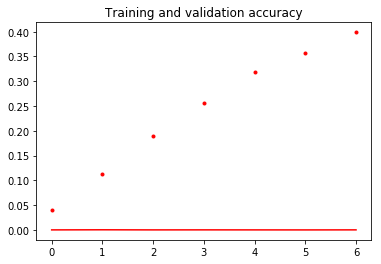

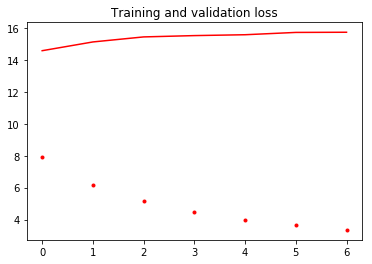

Transfer learning time: 5085.564309835434


In [4]:
####################################### Plotting the accuracy history #########################################################

def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()

if  DO_TRAINING:

    # Loading the history
    with open(HISTORY_FILE, 'rb') as f:  
        history = pickle.load(f)
        
    # Loading the time for training
    with open(MODEL_TIME, 'rb') as f: 
        training_time_tictoc = pickle.load(f)
        
    # plot the accuracy of the validation set and the training set
    plot_training(history)
   
    # Tell how long ran the training
    print('Transfer learning time: {}'.format(training_time_tictoc))
    

In [3]:
# Load previous model
if not DO_TRAINING:
    model = load_model(MODEL_FILE, compile=False)  

# --------------------------------------------PREDICTIONS----------------------------------------------

The prediction were made by test-time-augmentation(TTA).
According to https://www.kaggle.com/andrewkh/test-time-augmentation-tta-worth-it it gives better results.
Four versions of the predicted pictures were added:
    1. The original picture.
    2. The original picture fliped Left-Right.
    3. Translation of the picture in random amount. Left-Up(0-20), Right-Down(0-20) and rescale it.
    4. Translation of the picture like before and add flip left-right and bluring.

A threshold for adding 'new_whale' Id, to the predictions that don't have a clear identification.
It was added in the place(out of 5) that first didn't met the threshold.
At the end a submission file were created.

In [ ]:
#################################################### Predictions #########################################################
from keras.preprocessing   import image
# Function for finding the most common prediction number.
def Most_common_count(list_of_arg):
    return(Counter(list_of_arg).most_common(1)[0][1])

# Function for finding the most common prediction element.
def Most_common_element(list_of_arg):
    return(Counter(list_of_arg).most_common(1)[0][0])

# Function for finding the index.
def Index_of_value(list_of_arg, num_to_index):
    return(list_of_arg.index(num_to_index))

# Bounding boxes and resize
def Bounding_Boxes(image, bounding_cord):
    img = image[bounding_cord[1]:bounding_cord[3],bounding_cord[0]:bounding_cord[2],:]
    img_resize = cv2.resize(img,(IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_CUBIC)
    return (img_resize)

# Translation of the picture in random amount. Left-Up(0-20), Right-Down(0-20) and rescale it
def Augmentation_Scale_Trans(imagenp):
    translate_x_beg = random.randint(1,21)
    translate_y_beg = random.randint(1,21)
    translate_x_end = random.randint(1,21)
    translate_y_end = random.randint(1,21)
    crop_img = imagenp[translate_x_beg: -translate_x_end, translate_y_beg: -translate_y_end]
    img_resize = cv2.resize(crop_img,(IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_CUBIC)
    return(img_resize)

# Translation of the picture like before and add flip left-right and bluring.
def Augmentation_Scale_Trans_Flip_Blur(imagenp):
    translate_x_beg = random.randint(1,21)
    translate_y_beg = random.randint(1,21)
    translate_x_end = random.randint(1,21)
    translate_y_end = random.randint(1,21)
    crop_img = imagenp[translate_x_beg: -translate_x_end, translate_y_beg: -translate_y_end]
    fliplr_img = np.fliplr(crop_img)
    blur_img = cv2.filter2D(fliplr_img,-1,np.ones((5,5),np.float32)/25)  # Filter ot 5X5
    img_resize = cv2.resize(blur_img,(IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_CUBIC)
    return(img_resize)

# Function that does TTA
def my_TTA(img):

  # Set the indication if new whale predicted already for this picture to false.
  # Set the place to put the new_whale predication to the end of the list(ignored there).
  # Preprocess the image before insert it into the predic model.
  Is_new_whale       = False
  new_whale_location = NUMBER_OF_PREDICATIONS
  x                  = image.img_to_array(img)
  
  # Augmentation for the picture as described.
  original_img       = np.array(x) 

  original_img       = np.expand_dims(original_img, axis=0)
  original_img       = preprocess_input(original_img)

  predictions_orig   = model.predict(original_img, verbose=0)    
  flip_img           = np.array(Augmentation_Scale_Trans_Flip_Blur(np.array(x)))

  flip_img           = np.expand_dims(flip_img, axis=0)
  flip_img           = preprocess_input(flip_img)

  predictions_flip   = model.predict(flip_img, verbose=0)
  fliplr_img         = np.fliplr(np.array(x))

  fliplr_img         = np.expand_dims(fliplr_img, axis=0)
  fliplr_img         = preprocess_input(fliplr_img)

  predictions_fliplr = model.predict(fliplr_img, verbose=0)
  flipud_img         = np.array(Augmentation_Scale_Trans_Flip_Blur(np.array(x)))

  flipud_img         = np.expand_dims(flipud_img, axis=0)
  flipud_img         = preprocess_input(flipud_img)

  predictions_flipud = model.predict(flipud_img, verbose=0)
  
  # The first 5 predictions for each augmentation
  predictions_orig_ind   = predictions_orig.argsort()[0][::-1][:NUMBER_OF_PREDICATIONS]
  predictions_flip_ind   = predictions_flip.argsort()[0][::-1][:NUMBER_OF_PREDICATIONS]
  predictions_fliplr_ind = predictions_fliplr.argsort()[0][::-1][:NUMBER_OF_PREDICATIONS]
  predictions_flipud_ind = predictions_flipud.argsort()[0][::-1][:NUMBER_OF_PREDICATIONS]  
  llist           = []
  Best_guess_list = []
  Index_list      = [0,0,0,0]

  # For each picture find the correct prediction according the described logic.
  for i in range(NUMBER_OF_PREDICATIONS):
    llist        = [predictions_orig_ind[Index_list[0]], predictions_flip_ind[Index_list[1]], \
                     predictions_fliplr_ind[Index_list[2]], predictions_flipud_ind[Index_list[3]]]
    max_pred_num = [predictions_orig[0][Index_list[0]], predictions_flip[0][Index_list[1]], \
                        predictions_fliplr[0][Index_list[2]], predictions_flipud[0][Index_list[3]]]
 
    max_pred_value = max_pred_num[max_pred_num.index(max(max_pred_num))]

    # If the prediction is not above the threshold than put a new_whale classification in that spot
    # and ignore futher classifiaction below the thresholf for that picture.
    if not Is_new_whale and max_pred_value < THRESHOLD:
        Is_new_whale       = True
        new_whale_location = i
    
    # If there are more than one prediction agreement on the classification, choose this classification,
    # otherwise choose the highest prediction.
    if Most_common_count(llist) > 1:
        Best_guess_list.append(Most_common_element(llist))
        Index_list[Index_of_value(llist, Most_common_element(llist))] += 1
    else:
        Best_guess_list.append(max_pred_num.index(max_pred_value))
        Index_list[max_pred_num.index(max_pred_value)] += 1

  # Insert the 'new_whale' classification into the predictions.
  if Is_new_whale:
    Best_guess_list.insert(new_whale_location, NEW_WHALE_INDEX)
    del Best_guess_list[-1]

  return(Best_guess_list)       

# Turn the Id's into numbers-labels for decode them.
train_df        = pd.read_csv(TRAINING_FILE)
values          = np.array(train_df['Id'])
label_encoder   = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

# Load the previous created subbmision file and the test bounding boxes
test_df   = pd.read_csv(CONV_SUB_FILE).set_index('Image')
df_s_bbox = pd.read_csv(BB_TEST).set_index('Name')

# for each picture in the test do TTA and if it dosen't aleady exists in the submissin file, add it predication.
for fig in tqdm(test_df.index):
  image_path = '{}/{}'.format(TEST_FOLDER, fig)
  img = cv2.imread(image_path)

  # If the image doesn't have bounding box, just resize it.
  try:
      img = Bounding_Boxes(np.array(img), df_s_bbox.loc[fig])
  except:
      img     = cv2.imread(image_path)
      img     = cv2.resize(img,(IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_CUBIC)
  if test_df.loc[fig,'Id'] == ' ':
      test_df.loc[fig, 'Id'] = " ".join(label_encoder.inverse_transform(my_TTA(img)))

# Save submission file
test_df.to_csv(SUBMISSION_FILE, index=True)
